In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Familiarity Analysis Tidy

# 1. Import Packages -> MOVE TO APPENDIX LATER?
------------
-----
-----

In [1]:
import sys
stdout = sys.stdout # save in case some importe
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF
import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from copy import copy as copy
import operator as operator
import pylab
import statsmodels.api as sm

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob
import os

#pd.set_option('display.max_columns', 500) #uncomment for viewing of all variables in data frames

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import rpy2


%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)
sys.stdout = stdout

In [3]:
%%R
# Use in case the libraries are not available in the system
#install.packages("lme4")
#install.packages("car")
#install.packages("ggplot2")
#install.packages("broom")
#install.packages("arm")
#install.packages("ggplot2")
#install.packages("optimx")
#install.packages("multcomp")

In [4]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(pbkrtest)
library(broom)
library(dplyr)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)

<a id='LoadFunc'></a>
# 2. Defining Functions -> MOVE TO APPENDIX LATER?
-----------
-------
---------

## Calculate z-score (for Boldt(2016))

In [5]:
def zScore_df_VFCS(data): #
    
    # Convert data to float for better handling
    data.Value = [float(i) for i in data.Value]
    data.Familiarity = [float(i) for i in data.Familiarity]
    data.Confidence = [float(i) for i in data.Confidence]
    data.Assigned_price = [float(i) for i in data.Assigned_price]
    data.Real_price = [float(i) for i in data.Real_price]
    data.RT1 = [float(i) for i in data.RT1]
    data.RT2 = [float(i) for i in data.RT2]
    data.Size = [float(i) for i in data.Size]
    data.Real_size = [float(i) for i in data.Real_size]
    
    # z score value, familiarity and confidence
    num_subjects = max(data['Subject'])
    zValue = []
    zFam = []
    zConf = []
    zSize = []
    for sub in range(1,num_subjects+1):
        sub_values = data['Value'][data['Subject']==sub]
        sub_mean = sub_values.mean()
        sub_std = sub_values.std()
        for val in sub_values:
            zValue.append((val - sub_mean)/sub_std)
            
        sub_fam = data['Familiarity'][data['Subject']==sub]
        sub_mean = sub_fam.mean()
        sub_std = sub_fam.std()
        for fam in sub_fam:
            zFam.append((fam-sub_mean)/sub_std)
            
        sub_conf = data['Confidence'][data['Subject']==sub]
        sub_mean = sub_conf.mean()
        sub_std = sub_conf.std()
        for conf in sub_conf:
            zConf.append((conf-sub_mean)/sub_std)
            
        sub_size = data['Size'][data['Subject']==sub]
        sub_mean = sub_size.mean()
        sub_std = sub_size.std()
        for size in sub_size:
            zSize.append((size-sub_mean)/sub_std)
        
    data['zValue'] = zValue
    data['zFam'] = zFam
    data['zConf'] = zConf
    data['zSize'] = zSize
    
    return data

## Calculate z-score (for NN(2013))

In [6]:
def add_Value_Fam_LR(data): #
   
    # Add values and familiarities for left right item.
    # We assume that 1 is left and 0 is right
    data['RVal'] = np.where(data['Choice']==0, data['ChosenValue'],data['UnchosenValue'])
    data['LVal'] = np.where(data['Choice']==1, data['ChosenValue'],data['UnchosenValue'])  
    data['RFam'] = np.where(data['Choice']==0, data['ChosenFam'],data['UnchosenFam'])
    data['LFam'] = np.where(data['Choice']==1, data['ChosenFam'],data['UnchosenFam'])  
    
    # Change CHOICE to have RIGHT =1  and LEFT = 0
    data['Choice'] = np.where(data['Choice']==0, 1,0)  
    
    # z score value, familiarity
    num_subjects = max(data['Participant'])
    zRVal = []
    zLVal = []
    zRFam = []
    zLFam = []
    for sub in range(1,num_subjects+1):
        sub_RVal = data['RVal'][data['Participant']==sub]
        sub_mean = sub_RVal.mean()
        sub_std = sub_RVal.std()
        for rval in sub_RVal:
            zRVal.append((rval - sub_mean)/sub_std)
            
        sub_LVal = data['LVal'][data['Participant']==sub]
        sub_mean = sub_LVal.mean()
        sub_std = sub_LVal.std()
        for lval in sub_LVal:
            zLVal.append((lval-sub_mean)/sub_std)
            
        sub_RFam = data['RFam'][data['Participant']==sub]
        sub_mean = sub_RFam.mean()
        sub_std = sub_RFam.std()
        for rfam in sub_RFam:
            zRFam.append((rfam-sub_mean)/sub_std)
            
        sub_LFam = data['LFam'][data['Participant']==sub]
        sub_mean = sub_LFam.mean()
        sub_std = sub_LFam.std()
        for lfam in sub_LFam:
            zLFam.append((lfam-sub_mean)/sub_std)
        
    data['zRVal'] = zRVal
    data['zLVal'] = zLVal
    data['zRFam'] = zRFam
    data['zLFam'] = zLFam
    
    ## Calculate Split for confidence
    
    Splits_headers = ['ConfSplit']
    Splits_variables = ['Confidence']
    
    median_matrix=[]
    median_matrix_aux=[]
    Split_cols = []

    for h in range(len(Splits_variables)):
        median_matrix=[]
        for i in unique(data["Participant"]):
            median_matrix_aux=[]
    
            Splitdata = data.loc[data['Participant'] == i]
            Splitdata['TrialN'] = range(len(Splitdata))
            # Select the column to split
            Splitdata = Splitdata.loc[:,['TrialN',Splits_variables[h]]]
            SplitSort = Splitdata.values
            # Sort for confidence column
            SplitSort = SplitSort[np.argsort(SplitSort[:, 1])]
            #print(SplitSort)
            lenPart = len(Splitdata)
            #print(lenPart)
            # Generate column with median order
            median_low = [0] * int (lenPart/2)
            #print (median_low)
            if lenPart % 2 == 0:
                median_high = [1] * int (lenPart/2)
            else:
                median_high = [1] * int (lenPart/2 + 1)
            #print (median_high)            
            median_split_order = median_low + median_high
            
            #Attach split median order column (1 and 0)
            median_aux= np.column_stack((SplitSort,median_split_order))
            #Sort back to trial number
            SplitSorted = median_aux[np.argsort(median_aux[:, 0])]
            #print(len(SplitSorted))
            
            for kk in range(len(SplitSorted)): 
                if len(median_matrix_aux) == 0 :
                    median_matrix_aux = SplitSorted[0]
                else:
                    median_matrix_aux = np.vstack([median_matrix_aux, SplitSorted[kk]])
           
            # sort after adding both conditions    
            median_matrix_aux = median_matrix_aux[np.argsort(median_matrix_aux[:, 0])]

            #Extract only the column with the median split information
            median_matrix_aux = median_matrix_aux[:,2]

            #append to median matrix for the participants
            for k in range(len(median_matrix_aux)):    
                median_matrix.append(median_matrix_aux [k])

        median_matrix = pd.DataFrame(median_matrix,columns=[Splits_headers[h]])
        #print(len (median_matrix))
        #add new column (new split variable columns) to the split matrix
        if  h == 0:
            Split_cols = median_matrix
        else:
            Split_cols = pd.concat([Split_cols,median_matrix ],axis =1)

    data['ConfSplit'] = Split_cols

    
    return data

#### Taken from Folke et al. (2016)

### Calculate zScores for Folke 2016

In [34]:
def zScore_NHB2016(data):
    # z score value, familiarity
    subjects = data['Part'].unique()
    zRVal = []
    zLVal = []
    zDVal = []
    zDFam = []
    zTotVal = []
    zTotFam = []
    for sub in subjects:
        sub_RVal = data['RVal'][data['Part']==sub]
        sub_mean = sub_RVal.mean()
        sub_std = sub_RVal.std()
        for rval in sub_RVal:
            zRVal.append((rval - sub_mean)/sub_std)
            
        sub_LVal = data['LVal'][data['Part']==sub]
        sub_mean = sub_LVal.mean()
        sub_std = sub_LVal.std()
        for lval in sub_LVal:
            zLVal.append((lval-sub_mean)/sub_std)
            
        sub_DVal = data['DVal'][data['Part']==sub]
        sub_mean = sub_DVal.mean()
        sub_std = sub_DVal.std()
        for dval in sub_DVal:
            zDVal.append((dval-sub_mean)/sub_std)
            
        sub_DFam = data['DFam'][data['Part']==sub]
        sub_mean = sub_DFam.mean()
        sub_std = sub_DFam.std()
        for dfam in sub_DFam:
            zDFam.append((dfam-sub_mean)/sub_std)
            
        sub_TotVal = data['TotVal'][data['Part']==sub]
        sub_mean = sub_TotVal.mean()
        sub_std = sub_TotVal.std()
        for totval in sub_TotVal:
            zTotVal.append((totval-sub_mean)/sub_std)
       
        sub_TotFam = data['TotFam'][data['Part']==sub]
        sub_mean = sub_TotFam.mean()
        sub_std = sub_TotFam.std()
        for totfam in sub_TotFam:
            zTotFam.append((totfam-sub_mean)/sub_std)
    
    data['zRVal'] = zRVal
    data['zLVal'] = zLVal
    data['zDVal'] = zDVal
    data['zDFam'] = zDFam
    data['zTotVal'] = zTotVal
    data['zTotFam'] = zTotFam
    
    return data

In [8]:
data_expNHB.drop(data_expNHB.TotVal==0)

NameError: name 'data_expNHB' is not defined

### Plot distributions

In [ ]:
def participant_densities(data, var, xlim=(0,100), rug=True):
    # a counter that tells us where a given participant's data should be plotted
    order = 1

    # a list of all the participants in the dataset
    participants = data.loc[:, 'Part'].unique()

    # defining the figure size
    sns.set_style('white')
    fig = figure(figsize=(15,70))

    for x in participants:
        # defining the sub figures
            sub={}
            sub['%s' % x] = plt.subplot(len(participants)/2, 3, order)
            sns.kdeplot(data.loc[data['Part'] == x, var].values, ax = sub['%s' % x], shade=True)
            #if rug==True:
            #    sns.rugplot(data.loc[data['Part'] == x, var].values, ax = sub['%s' % x])
            sub['%s' % x].set_title('participant %s' % x)
            #sub['%s' % x].set_xlim(xlim)
            order += 1

### Split variable into participantwise quantiles

In [9]:
def parsplit(DF, input, quantiles):
    qvalues = pd.qcut(DF[input], quantiles, labels = range(1, quantiles+1))
    return qvalues

### Full simple logistic graph

In [10]:
def logisticplot_all (moderator, modhigh, modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='SubNo'):
    
    sns.set(font_scale=1.5, style='white')
    fig = figure(figsize=(8,7))
    fig.set_facecolor('white')
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    # Paula used these dictionaries to store the values of the predictive lines for all the participants.
    logit_low = {}
    logit_high = {}

    # I think this defines the problem space
    X_test = np.linspace(-5,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==0)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==0)].index, yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()


    # fitting the predictive logistic model for the high_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==1)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==1)].index, yaxis])
    logit_high = model(X_test * clf.coef_ + clf.intercept_).ravel()

    #Plotting the predictive lines
    line_high = sub.plot(X_test, logit_high, color=modhighcol, linewidth=5, label=modhigh, zorder=6)
    line_low = sub.plot(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5)


    #Plotting the binned data
    data['DVBin2'] = data.groupby(parvar).apply(parsplit, input=xaxis, quantiles=4).values
    
    # determine the x coordinates
    x_cords= data.groupby('DVBin2')[xaxis].mean()
    
    # determine low y coordinates
    y_cords_low = data.loc[(data[moderator]==0), :].groupby('DVBin2')[yaxis].mean().values
    
    # determine low y standard errors
    test = pd.DataFrame(data.loc[(data[moderator]==0), :].groupby(['DVBin2', parvar])[yaxis].mean()).reset_index()
    y_low_error = test.groupby('DVBin2')[yaxis].std()/np.sqrt(len(test[parvar].unique()))
    
    
    # determine high y coordinates
    y_cords_high = data.loc[(data[moderator]==1), :].groupby('DVBin2')[yaxis].mean().values
    
    # determine high y standard errors
    test2 = pd.DataFrame(data.loc[data[moderator]==1, :].groupby(['DVBin2', parvar])[yaxis].mean()).reset_index()
    y_high_error = test2.groupby('DVBin2')[yaxis].std()/np.sqrt(len(test[parvar].unique()))
    
    # plot the low points
    plt.scatter(x_cords, y_cords_low, c=modlowcol, marker='D', s=60, zorder=1)
    # plot low error bars
    plt.errorbar(x_cords, y_cords_low, yerr=y_low_error, fmt='o', zorder=3, c=modlowcol)
    
    # plot the high points
    plt.scatter(x_cords, y_cords_high, c=modhighcol, marker='o', s=60, zorder=2)
    # plot high error bars
    plt.errorbar(x_cords, y_cords_high, yerr=y_high_error, fmt='o', zorder=4, c=modhighcol)
    
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(-5, 5)

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(loc=2, prop={'size':20})
    sns.despine()

### Full simple logistic graph (no bins)

In [11]:
def logisticplot_simpl (moderator, modhigh, modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='SubNo'):
    
    sns.set(font_scale=1.5, style='white')
    fig = figure(figsize=(8,7))
    fig.set_facecolor('white')
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    # Paula used these dictionaries to store the values of the predictive lines for all the participants.
    logit_low = {}
    logit_high = {}

    # I think this defines the problem space
    X_test = np.linspace(-5,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==0)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==0)].index, yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()
    print ('Low measure coef',clf.coef_)
    
    # fitting the predictive logistic model for the high_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==1)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==1)].index, yaxis])
    logit_high = model(X_test * clf.coef_ + clf.intercept_).ravel()
    print ('High measure coef',clf.coef_)



    #Plotting the predictive lines
    line_high = sub.plot(X_test, logit_high, color=modhighcol, linewidth=5, label=modhigh, zorder=6)
    line_low = sub.plot(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5) 
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(-5, 5)

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(loc=2, prop={'size':20})
    sns.despine()

### Regression Coefficients Plot

In [12]:
def Coefpresplot(regtable, intercept=False, title='Regression Coefficients', size='big', ylimits=(), ymultiple=0.5, ticklabsize=25, n_ET_predictors = 0):

    # Import itertools so that we can iterate through the colours
    import itertools
    
    # Import locators so that we can tidy up the yaxis
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    
    # rounding function to get edges to even 0.5 values
    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def round_to_5(n):
        return round_to(n, 0.5)

    # Set seaborn style for the plot
    sns.set(style='white')
    
    # Generate the figure
    if size=='big':
        fig = plt.figure(figsize=[20,8])
    elif size=='long':
        fig = plt.figure(figsize=[20,4])
    elif size=='narrow':
        fig = plt.figure(figsize=[10,4])
        
    fig.suptitle(title, fontsize=20)
    gs = GridSpec(1,1,bottom=0.18,left=0.18,right=0.82)
    ax = fig.add_subplot(gs[0,0])
    
    # Set axis limits based on whether to include the intercept or not    
    if intercept == True:
        XLim = (0.75, len(regtable.columns) + 0.25)
        YLim = (round_to_5(regtable.loc['CImin', :].min()-0.1), round_to_5(regtable.loc['CImax', :].max()+0.2))
    else:
        XLim = (0.75, len(regtable.columns) - 0.75)
        YLim = (round_to_5(regtable.loc['CImin', regtable.columns[1]:].min()-0.2), round_to_5(regtable.loc['CImax', regtable.columns[1]:].max()+0.2))
    if ylimits != ():
        YLim = ylimits
    ax.set_xlim(XLim)
    ax.set_ylim(YLim)
    
    # Draw a line through the 0-value on the y-axis
    line = ax.plot(XLim, [0, 0], color='black', ls='--', alpha = 0.5, lw=3)
    
    
    # If intercept is true, plot the coefficient for the intercept
    if intercept == True:
        Coefficients = regtable.columns
    else:
        Coefficients = regtable.columns[1:]
        
    # Determine the colours for the coefficients based on the n_ET_variable
    n_predictors = len(Coefficients)
    n_non_ET_predictors = n_predictors - n_ET_predictors
    
    colourlist = ['#000000'] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    
        
    # Plot all the coefficients with 95% CI
    position = 0
    for Coefficient in Coefficients:
        position += 1
        ax.plot(position, regtable.loc['coefficient', Coefficient], marker='o', ms=8, color=colourlist[position-1],)
        ax.errorbar(position, regtable.loc['coefficient', Coefficient],
                    yerr=regtable.loc['se', Coefficient]*1.96, lw=2, color=colourlist[position-1])

    # Setting the x-axis major tick's location
    ax.set_xticks(range(1, position+1))
    
    # set the y-axis major tick position
    ax.yaxis.set_major_locator(MultipleLocator(ymultiple))


    # Setting the x-axis major tick's label
    if intercept == True:
        ax.set_xticklabels(regtable.columns, rotation=40)
    else: 
        ax.set_xticklabels(regtable.columns[1:], rotation=40)
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabsize)
    ax.set_ylabel('Fixed Effects Coefficients', fontsize=18)
    
    # Autoformats the ticklabels for the xaxis
    fig.autofmt_xdate()
    
    sns.despine()

In [13]:
def Coefpresplot2(regtable,regtable2, intercept=False, title='Regression Coefficients', size='big', ylimits=(), ymultiple=0.5, ticklabsize=25, n_ET_predictors = 0):

    # Import itertools so that we can iterate through the colours
    import itertools
    
    # Import locators so that we can tidy up the yaxis
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    
    # rounding function to get edges to even 0.5 values
    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def round_to_5(n):
        return round_to(n, 0.5)

    # Set seaborn style for the plot
    sns.set(style='white')
    
    # Generate the figure
    if size=='big':
        fig = plt.figure(figsize=[20,8])
    elif size=='long':
        fig = plt.figure(figsize=[20,4])
    elif size=='narrow':
        fig = plt.figure(figsize=[10,4])
        
    fig.suptitle(title, fontsize=20)
    gs = GridSpec(1,1,bottom=0.18,left=0.18,right=0.82)
    ax = fig.add_subplot(gs[0,0])
    

    # Set axis limits based on whether to include the intercept or not    
    
       
    
    if intercept == True:
        
        XLim = (0.75, len(regtable.columns) + 0.25)
        
        #Determine the Ymax and Ymin for both regresions results
        if round_to_5(regtable.loc['CImin', :].min()) < round_to_5(regtable2.loc['CImin', :].min()):
            Ymin = round_to_5(regtable.loc['CImin', :].min()-0.5)
        else :
            Ymin = round_to_5(regtable2.loc['CImin',:].min()-0.5)
        if round_to_5(regtable.loc['CImax', :].max()) > round_to_5(regtable2.loc['CImax', :].max()):
            Ymax = round_to_5(regtable.loc['CImax', :].max()+0.5)
        else :
            Ymax = round_to_5(regtable2.loc['CImax', :].max()+0.5)      

        YLim = (Ymin, Ymax)    
    else:
        XLim = (0.75, len(regtable.columns) - 0.75)
        
        #Determine the Ymax and Ymin for both regresions results
        if round_to_5(regtable.loc['CImin', regtable.columns[1]:].min()) < round_to_5(regtable2.loc['CImin', regtable.columns[1]:].min()):
            Ymin = round_to_5(regtable.loc['CImin', regtable.columns[1]:].min()-0.5)
        else :
            Ymin = round_to_5(regtable2.loc['CImin',regtable.columns[1]:].min()-0.5)
        if round_to_5(regtable.loc['CImax', regtable.columns[1]:].max()) > round_to_5(regtable2.loc['CImax', regtable.columns[1]:].max()):
            Ymax = round_to_5(regtable.loc['CImax', regtable.columns[1]:].max()+0.5)
        else :
            Ymax = round_to_5(regtable2.loc['CImax', regtable.columns[1]:].max()+0.5)      
        
        YLim = (Ymin, Ymax)
    
    if ylimits != ():
        YLim = ylimits
    ax.set_xlim(XLim)
    ax.set_ylim(YLim)
    
    # Draw a line through the 0-value on the y-axis
    line = ax.plot(XLim, [0, 0], color='black', ls='--', alpha = 0.5, lw=3)
    
    
    # If intercept is true, plot the coefficient for the intercept
    # both regtable should have the same regressors (and in the same order)

    if intercept == True:
        Coefficients = regtable.columns
 #       Coefficients2 = regtable2.columns
    else:
        Coefficients = regtable.columns[1:]
#        Coefficients2 = regtable2.columns[1:]
        
    # Determine the colours for the coefficients based on the n_ET_variable
    n_predictors = len(Coefficients)
    n_non_ET_predictors = n_predictors - n_ET_predictors
    
    colourlist = ['#000000'] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    
        
    # Plot all the coefficients with 95% CI
    position = 0
    for Coefficient in Coefficients:
        position += 1
        ax.plot(position-0.1, regtable.loc['coefficient', Coefficient], marker='o', ms=8, color='blue',label = 'Like')
        ax.plot(position+0.1, regtable2.loc['coefficient', Coefficient], marker='X', ms=8, color='red', label = 'Dislike')


        ax.errorbar(position-0.1, regtable.loc['coefficient', Coefficient],
                    yerr=regtable.loc['se', Coefficient]*1.96, lw=2, color='blue')
        ax.errorbar(position+0.1, regtable2.loc['coefficient', Coefficient],
                    yerr=regtable2.loc['se', Coefficient]*1.96, lw=2, color='red')
        
        if position == 1:
            ax.legend( prop={'size': 20})

 
    # Setting the x-axis major tick's location
    ax.set_xticks(range(1, position+1))
    
    # set the y-axis major tick position
    ax.yaxis.set_major_locator(MultipleLocator(ymultiple))

    # Setting the x-axis major tick's label
    if intercept == True:
        ax.set_xticklabels(regtable.columns, rotation=40)
    else: 
        ax.set_xticklabels(regtable.columns[1:], rotation=40)
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabsize)
    ax.set_ylabel('Fixed Effects Coefficients', fontsize=18)
    
    # Autoformats the ticklabels for the xaxis
    fig.autofmt_xdate()

    sns.despine()

In [14]:
def regtable(fix, fix_se, names):
    fixed_betas = DF(np.array(fix)); fixed_betas = fixed_betas.transpose(); fixed_betas.columns = names
    fixed_betas.loc[1] = np.array(fix_se)
    fixed_betas.loc[2] = fixed_betas.loc[0] - (fixed_betas.loc[1]*1.96)
    fixed_betas.loc[3] = fixed_betas.loc[0] + (fixed_betas.loc[1]*1.96)
    fixed_betas.index = ['coefficient', 'se', 'CImin', 'CImax']
    return fixed_betas

In [15]:
def rgb2hex(r,g,b):
    hex = "#{:02x}{:02x}{:02x}".format(r,g,b)
    return hex

# Add some Variables

## Colors for the studies

In [16]:
colors=sns.color_palette("colorblind") #choose color palette
colorFF=colors[0] # choose color
colorFF = [i * 255 for i in colorFF] # convert to range 1:255
colorFF=rgb2hex(int(colorFF[0]),int(colorFF[1]),int(colorFF[2])) # convert to hex value
colorNN=colors[1]
colorNN = [i * 255 for i in colorNN]
colorNN=rgb2hex(int(colorNN[0]),int(colorNN[1]),int(colorNN[2]))
colorNHB=colors[2]
colorNHB = [i * 255 for i in colorNHB]
colorNHB=rgb2hex(int(colorNHB[0]),int(colorNHB[1]),int(colorNHB[2]))
# Import to R
%R -i colorFF 
%R -i colorNN
%R -i colorNHB

<a id='load'></a>
# 3. Load data and excluding participants
-----------
-------
---------

## Load data Delgado (2018)

Participants 6, 33, 7, 17, 25, 30 should be excluded.Additionally, it was checked that trials in which participants did not fixate in any of the items were were skipped already. Therefore, 7 participants have been excluded.
Total number subjects = 40
Number of subjects remaining = =33

In [43]:
# Load data all participants
data_expFF = pd.read_csv('D:\BDMLAB\Fam_datasets\DataFoodFramingNotebook_v1.csv') 
# data_exp1 = pd.read_csv('D:\BDMLAB\FF2018\Output\DataFoodFramingNotebook_v1.csv') 

for i in [6, 7, 17, 25, 30, 33]:
    data_expFF = data_expFF[(data_expFF.Part != i)]
print (data_expFF["Part"].unique())
print ('Number of participants: ' + str(len(data_expFF["Part"].unique())))

[ 1  2  3  4  5  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 26 27 28
 29 31 32 34 35 36 37 38 39]
Number of participants: 33


## Load data De Martino (2013)

In [44]:
# Load data all participants
data_expNN = pd.read_csv('D:\BDMLAB\Fam_datasets\Data_NN_2013.csv') 
# data_exp1 = pd.read_csv('/Users/bdmlab/Documents/GiTs/FF2018/FF2018/Additional Datasets/Data_NN_2013.csv') 

#This function applies the transformations required for 
data_expNN = add_Value_Fam_LR(data_expNN)


#for i in [6, 7, 17, 25, 30, 33]:
#    data_exp1 = data_exp1[(data_exp1.Part != i)]
#print (data_exp1["Part"].unique())
#print ('Number of participants: ' + str(len(data_exp1["Part"].unique())))

#data_expNN.to_csv("DataNN_test.csv")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Load data Boldt (2016)

In this case we don't have alternatives (e.g. right or left item) to be selected, therefore, it may be more complicated to deal with this dataset in conjunction with the others

In [45]:
# Load data all participants
data_expAB = pd.read_csv('D:\BDMLAB\Fam_datasets\Data_Annika.csv') 
#data_exp1 = pd.read_csv('/Users/bdmlab/Documents/GiTs/FF2018/FF2018/Additional Datasets/Data_NN_2013.csv') 

#add z-score and value and familiarity left/right columns to this dataset
data_expAB = zScore_df_VFCS(data_expAB)

#for i in [6, 7, 17, 25, 30, 33]:
#    data_exp1 = data_exp1[(data_exp1.Part != i)]
#print (data_exp1["Part"].unique())
#print ('Number of participants: ' + str(len(data_exp1["Part"].unique())))

# Load data Folke (2016)

In [46]:
# Load data all participants
data_expNHB = pd.read_csv('D:\BDMLAB\Fam_datasets\\NHB_Exp1_Familiarity_Data.csv') 

# 4. Set up Datasets for Analysis
-------------------------------------------

### List of parameters available for analysis

In [47]:
figsize(15, 15)
#Transform to numeric values in the dataframe
data_expFF = data_expFF.apply(pd.to_numeric, errors='ignore')
data_expNN = data_expNN.apply(pd.to_numeric, errors='ignore')
data_expAB = data_expAB.apply(pd.to_numeric, errors='ignore')
data_expNHB = data_expNHB.apply(pd.to_numeric, errors='ignore')


#Show the list of data columns
varsFF = pd.DataFrame(list(data_expFF))
varsNN = pd.DataFrame(list(data_expNN))
display_titles = pd.concat([varsFF,varsNN], ignore_index=True, axis=1)
display_titles
#pd.DataFrame(display_titles, columns=["FF2018", "NN2013","AB2016"])
display_titles.to_csv
display_titles.to_csv("names_columns.csv")



We will use the variable names used in DeMartino2013 for our dataset Delgado2018 and Folke2016.

## Rename the variables in Delgado2018

In [48]:
data_expFF=data_expFF.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

### Separate only like condition for Delgado2018

In [49]:
#Select Condition 
data_expFF = data_expFF.loc[data_expFF['BlockCond'] == 1] # 1 = Like, 2 = Dislike

## Rename the variables in DeMartino2013

In [50]:
data_expNN=data_expNN.rename(index=str, columns={"Participant":"Part",
                            "ChosenValue":"ChosenVal",
                            "UnchosenValue":"UnchosenVal",
                            "DiffValue":"DVal",
                            "AbsDiffValue":"AbsDVal",
                            "TotalValue":"TotVal",
                            "DiffFam":"DFam",
                            "AbsDiffFam":"AbsDFam",
                            "TotalFam":"TotFam",
                            "Confidence":"Conf" ,
                            "zChosenValue":"zChosenVal",
                            "zUnchosenValue":"zUnchosenVal",
                            "zDiffValue":"zDVal",
                            "zAbsDiffValue":"zAbsDVal",
                            "zTotalValue":"zTotVal",
                            "zDiffFam":"zDFam",
                            "zAbsDiffFam":"zAbsDFam",
                            "zTotalFam":"zTotFam",
                            "zConfidence":"zConf"  })

## Rename the variables in Folke2016

Eye variables weren't renamed yet

In [51]:
data_expNHB=data_expNHB.rename(index=str, columns={"SubNo":"Part",
                                                  "choice":"Choice",
                                                  "BDM_left":"LVal",
                                                  "BDM_right":"RVal",
                                                  "Diff_Value":"DVal",
                                                  "confidence":"Conf",
                                                  "FamLeft":"LFam",
                                                  "FamRight":"RFam",
                                                  "Diff_Fam":"DFam",
                                                  "zDV":"zDVal",
                                                  "zAbsDV":"zAbsDVal",
                                                  "zConfidence":"zConf",
                                                  "ZFamLeft":"zLFam",
                                                  "ZFamRight":"zRFam",
                                                   "Diff_Fam":"DFam",
                                                  "absDV":"AbsDVal"})

In [52]:
data_expNHB.Choice[data_expNHB['Choice']==-1] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Create Variables that are missing in Folke2016

In [56]:
data_expFF = data_expFF[data_expFF.TotVal!=0]
data_expNN = data_expNN[data_expNN.TotVal!=0]
data_expNHB = data_expNHB[data_expNHB.TotVal!=0]

In [111]:
print(len(data_expNHB.Part.unique()))
for i in range(0,len(data_expNHB.Part.unique())):
    tmp=pd.DataFrame([data_expNHB['TotFam'][data_expNHB.Part==data_expNHB.Part.unique()[i]]]).transpose()
    print(tmp.std())
data_expNHB[data_expNHB.Part== data_expNHB.Part.unique()[3]]

28
TotFam    1.182597
dtype: float64
TotFam    4.964212
dtype: float64
TotFam    2.362077
dtype: float64
TotFam    0.0
dtype: float64
TotFam    1.182597
dtype: float64
TotFam    1.167967
dtype: float64
TotFam    3.060239
dtype: float64
TotFam    2.515226
dtype: float64
TotFam    2.983918
dtype: float64
TotFam    2.478569
dtype: float64
TotFam    2.344985
dtype: float64
TotFam    1.078993
dtype: float64
TotFam    4.050813
dtype: float64
TotFam    3.190192
dtype: float64
TotFam    3.693401
dtype: float64
TotFam    3.886599
dtype: float64
TotFam    3.192565
dtype: float64
TotFam    2.939416
dtype: float64
TotFam    1.979233
dtype: float64
TotFam    4.624279
dtype: float64
TotFam    3.871498
dtype: float64
TotFam    3.842071
dtype: float64
TotFam    4.846091
dtype: float64
TotFam    3.018077
dtype: float64
TotFam    2.626961
dtype: float64
TotFam    3.909141
dtype: float64
TotFam    4.875972
dtype: float64
TotFam    4.385237
dtype: float64


,Part,pair,trialID,stimleft,stimright,Choice,Conf,RT,LVal,RVal,...,TotVal,TotFam,zRVal,zLVal,zDFam,ChosenVal,UnchosenVal,ChosenFam,UnchosenFam,zAbsDFam
720,108,1,1,1,11,1,4.87,4.69,1.584,1.596,...,3.180,20,-0.059109,-0.081104,-0.081104,1.596,1.584,10,10,0.081104
721,108,2,2,10,3,1,4.09,9.80,1.200,2.820,...,4.020,20,2.184300,-0.784918,-0.784918,2.820,1.200,10,10,0.784918
722,108,3,3,16,6,1,4.79,7.63,2.544,1.848,...,4.392,20,0.402769,1.678433,1.678433,1.848,2.544,10,10,1.678433
723,108,4,4,15,11,1,5.57,2.54,1.020,1.596,...,2.616,20,-0.059109,-1.114832,-1.114832,1.596,1.020,10,10,1.114832
724,108,5,5,5,11,0,5.06,3.78,1.368,1.596,...,2.964,20,-0.059109,-0.476999,-0.476999,1.368,1.596,10,10,0.476999
725,108,6,6,5,2,0,5.80,1.97,1.368,0.984,...,2.352,20,-1.180814,-0.476999,-0.476999,1.368,0.984,10,10,0.476999
726,108,7,7,7,11,1,4.20,10.43,1.500,1.596,...,3.096,20,-0.059109,-0.235063,-0.235063,1.596,1.500,10,10,0.235063
727,108,8,8,6,15,0,5.06,5.94,1.848,1.020,...,2.868,20,-1.114832,0.402769,0.402769,1.848,1.020,10,10,0.402769
728,108,9,9,14,10,0,5.30,3.74,2.028,1.200,...,3.228,20,-0.784918,0.732682,0.732682,2.028,1.200,10,10,0.732682
729,108,10,10,5,9,0,4.48,4.95,1.368,1.296,...,2.664,20,-0.608965,-0.476999,-0.476999,1.368,1.296,10,10,0.476999


In [53]:
data_expNHB=data_expNHB[data_expNHB.Part!= data_expNHB.Part.unique()[3]]

In [55]:


data_expNHB['TotVal']=data_expNHB['LVal']+data_expNHB['RVal']
#data_expNHB['zTotVal']=data_expNHB['TotVal'].transform(lambda x: (x - x.mean()) / x.std())
data_expNHB['TotFam']=data_expNHB['LFam']+data_expNHB['RFam']
#data_expNHB['zTotFam']=data_expNHB['TotFam'].transform(lambda x: (x - x.mean()) / x.std())
#data_expNHB['zDFam']=data_expNHB['DFam'].transform(lambda x: (x - x.mean()) / x.std())

data_expNHB = zScore_NHB2016(data_expNHB)

data_expNHB['ChosenVal']=data_expNHB['Choice']
data_expNHB['UnchosenVal']=data_expNHB['Choice']
data_expNHB.loc[data_expNHB['Choice']==1,'ChosenVal']=data_expNHB.loc[data_expNHB['Choice']==1,'RVal']
data_expNHB.loc[data_expNHB['Choice']==0,'ChosenVal']=data_expNHB.loc[data_expNHB['Choice']==0,'LVal']
data_expNHB.loc[data_expNHB['Choice']==0,'UnchosenVal']=data_expNHB.loc[data_expNHB['Choice']==0,'RVal']
data_expNHB.loc[data_expNHB['Choice']==1,'UnchosenVal']=data_expNHB.loc[data_expNHB['Choice']==1,'LVal']

data_expNHB['ChosenFam']=data_expNHB['Choice']
data_expNHB['UnchosenFam']=data_expNHB['Choice']
data_expNHB.loc[data_expNHB['Choice']==1,'ChosenFam']=data_expNHB.loc[data_expNHB['Choice']==1,'RFam']
data_expNHB.loc[data_expNHB['Choice']==0,'ChosenFam']=data_expNHB.loc[data_expNHB['Choice']==0,'LFam']
data_expNHB.loc[data_expNHB['Choice']==0,'UnchosenFam']=data_expNHB.loc[data_expNHB['Choice']==0,'RFam']
data_expNHB.loc[data_expNHB['Choice']==1,'UnchosenFam']=data_expNHB.loc[data_expNHB['Choice']==1,'LFam']

data_expNHB['zAbsDFam']=data_expNHB['zDFam'].abs()

## Load Data into R

In [57]:
%R -i data_expFF

In [58]:
%R -i data_expNN

In [60]:
%R -i data_expNHB

# 5. Data Analysis
----------------------
--------------------------
------------------------------------

## STUFF BEFORE REGRESSION ANALYSIS -> SEE PRADY'S CODE

In [61]:
data_expNHB

,Part,pair,trialID,stimleft,stimright,Choice,Conf,RT,LVal,RVal,...,zRVal,zLVal,zDFam,zTotVal,zTotFam,ChosenVal,UnchosenVal,ChosenFam,UnchosenFam,zAbsDFam
0,101,1,1,2,15,0,6.00,2.53,1.764,0.936,...,-0.808664,0.945295,0.000000,0.100004,0.951296,1.764,0.936,10,10,0.000000
1,101,2,2,13,8,1,5.10,2.47,1.500,0.924,...,-0.834084,0.386062,-0.790983,-0.327919,0.105700,0.924,1.500,9,10,0.790983
2,101,3,3,6,16,1,4.63,3.17,1.164,2.508,...,2.521317,-0.325690,-1.581966,1.607035,-0.739897,2.508,1.164,8,10,1.581966
3,101,4,4,9,2,1,4.05,3.08,1.020,1.764,...,0.945295,-0.630726,1.581966,0.230241,-0.739897,1.764,1.020,10,8,1.581966
4,101,5,5,7,5,0,2.45,1.81,1.752,1.032,...,-0.605307,0.919876,0.000000,0.230241,0.951296,1.752,1.032,10,10,0.000000
5,101,6,6,4,1,1,6.00,4.91,1.032,0.984,...,-0.706986,-0.605307,0.000000,-0.960500,0.951296,0.984,1.032,10,10,0.000000
6,101,7,7,14,16,1,4.98,3.16,1.644,2.508,...,2.521317,0.691098,-1.581966,2.351247,-0.739897,2.508,1.644,8,10,1.581966
7,101,8,8,10,4,1,1.00,3.94,0.828,1.032,...,-0.605307,-1.037442,1.581966,-1.202369,-0.739897,1.032,0.828,10,8,1.581966
8,101,9,9,16,9,0,4.59,4.53,2.508,1.020,...,-0.630726,2.521317,0.000000,1.383771,-2.431090,2.508,1.020,8,8,0.000000
9,101,10,10,7,16,1,1.51,3.59,1.752,2.508,...,2.521317,0.919876,-1.581966,2.518695,-0.739897,2.508,1.752,8,10,1.581966


# Regression Analyses
---------
-------

# Predicting Choice
---------------

### Choice ~ zDVal + zConf + zTotVal + zDVal:zConf + zDVal:zTotVal

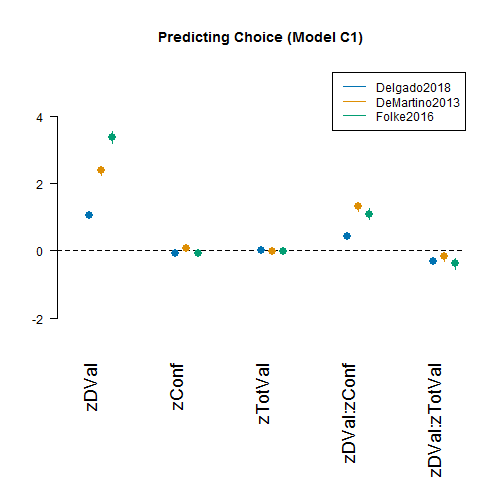

In [62]:
%%R
# Figure replicating Folke 2016.

title_plot = "Predicting Choice (Model C1)"

ModelChoiceFF_1 <- glm(Choice ~ zDVal + zConf + zTotVal + zDVal:zConf + zDVal:zTotVal , data=data_expFF, family=binomial(link="logit"))
ModelChoiceNN_1 <- glm(Choice ~ zDVal + zConf + zTotVal + zDVal:zConf + zDVal:zTotVal , data=data_expNN, family=binomial(link="logit"))
ModelChoiceNHB_1 <- glm(Choice ~ zDVal + zConf + zTotVal + zDVal:zConf + zDVal:zTotVal , data=data_expNHB, family=binomial(link="logit"))

# save string containing the predictors
Predictors_1 = "zDVal + zConf + zTotVal + zDVal:zConf + zDVal:zTotVal"

coefplot(ModelChoiceFF_1,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-2.6, 5) ,main=title_plot)
coefplot(ModelChoiceNN_1, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
coefplot(ModelChoiceNHB_1, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018", "DeMartino2013","Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)

### Choice ~ LVal + RVal + zConf
Originally hat zTotVal included, but the coefficient came out as NA_real_ for dataset Folke2016 (probably because of linear relation between LVal, RVal and zTotVal [Wondering why this was not the case for Delgado2018 and DeMartino2013]). Hence, zTotVal was excluded.
(-> ask prady why he included it)

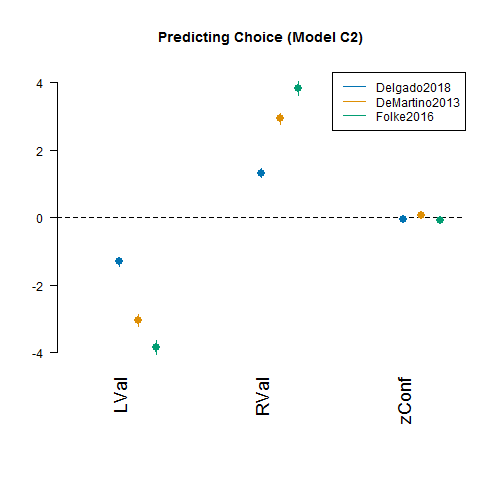

In [63]:
%%R
title_plot = "Predicting Choice (Model C2)"

ModelChoiceFF_2 <- glm(Choice ~ LVal + RVal + zConf , data=data_expFF, family=binomial(link="logit"))
ModelChoiceNN_2 <- glm(Choice ~ LVal + RVal + zConf , data=data_expNN, family=binomial(link="logit"))
ModelChoiceNHB_2 <- glm(Choice ~ LVal + RVal + zConf , data=data_expNHB, family=binomial(link="logit"))

# save string containing the predictors
Predictors_2 = "LVal + RVal + zConf"

coefplot(ModelChoiceFF_2,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-4, 4) ,main=title_plot)
coefplot(ModelChoiceNN_2, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
coefplot(ModelChoiceNHB_2, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018", "DeMartino2013","Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)


### Choice ~ LFam + RFam + zConf
Same problem with zTotFam in Folke2016 as before with zTotVal. zTotFam was excluded as predictor

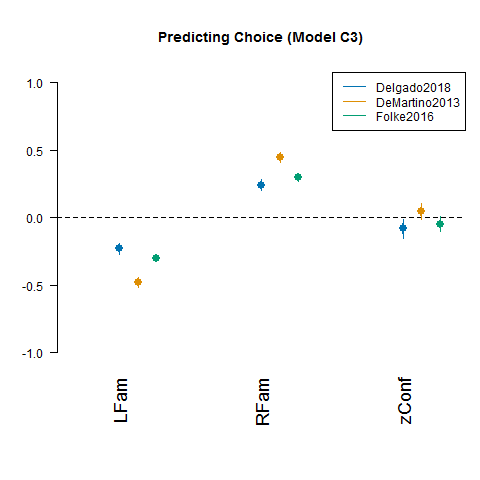

In [64]:
%%R
# regression for choice and familiarity
title_plot = "Predicting Choice (Model C3)"

ModelChoiceFF_3 <- glm(Choice ~ LFam + RFam + zConf , data=data_expFF, family=binomial(link="logit"))
ModelChoiceNN_3 <- glm(Choice ~ LFam + RFam + zConf, data=data_expNN, family=binomial(link="logit"))
ModelChoiceNHB_3 <- glm(Choice ~ LFam + RFam + zConf, data=data_expNHB, family=binomial(link="logit"))

# save string containing the predictors
Predictors_3 = "LFam + RFam + zConf"

coefplot(ModelChoiceFF_3,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-1.0, 1.0) ,main=title_plot)
coefplot(ModelChoiceNN_3, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
coefplot(ModelChoiceNHB_3, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018", "DeMartino2013","Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)

### Choice ~ LFam + RFam + zConf
As above zTotFam was excluded.

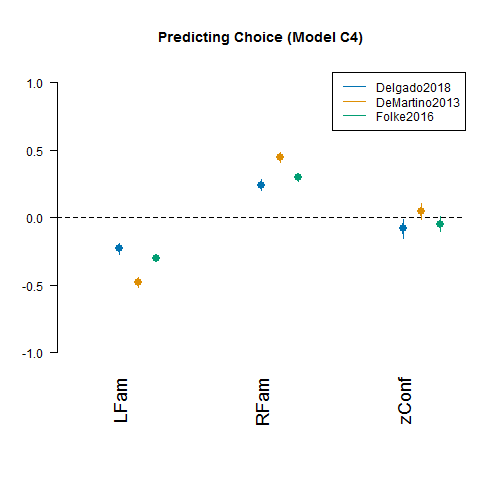

In [65]:
%%R
# regression for choice and familiarity
title_plot = "Predicting Choice (Model C4)"

ModelChoiceFF_4<- glm(Choice ~ LFam + RFam + zConf, data=data_expFF, family=binomial(link="logit"))
ModelChoiceNN_4 <- glm(Choice ~ LFam + RFam + zConf, data=data_expNN, family=binomial(link="logit"))
ModelChoiceNHB_4 <- glm(Choice ~ LFam + RFam + zConf, data=data_expNHB, family=binomial(link="logit"))

# save string containing the predictors
Predictors_4 = "LFam + RFam + zConf"

coefplot(ModelChoiceFF_4,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-1.0, 1.0) ,main=title_plot)
coefplot(ModelChoiceNN_4, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
coefplot(ModelChoiceNHB_4, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018", "DeMartino2013","Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)

### Choice ~ zDFam + zConf +zTotFam + zDFam:zConf + zDFam:TotFam

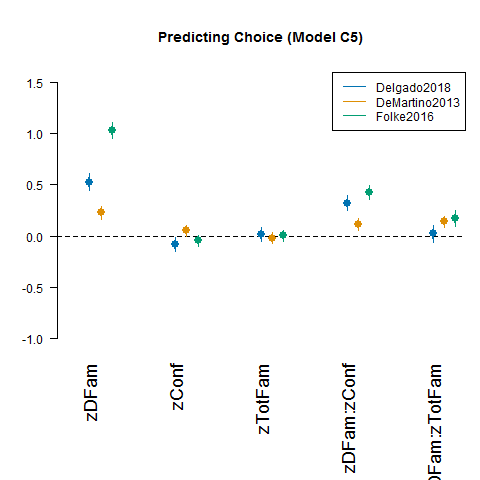

In [66]:
%%R
#regression for confidence and familiarity
title_plot = "Predicting Choice (Model C5)"

ModelChoiceFF_5 <- glm(Choice ~ zDFam + zConf +zTotFam + zDFam:zConf + zDFam:zTotFam , data=data_expFF, family=binomial(link="logit"))
ModelChoiceNN_5 <- glm(Choice ~ zDFam + zConf +zTotFam + zDFam:zConf + zDFam:zTotFam , data=data_expNN, family=binomial(link="logit"))
ModelChoiceNHB_5 <- glm(Choice ~ zDFam + zConf +zTotFam + zDFam:zConf + zDFam:zTotFam , data=data_expNHB, family=binomial(link="logit"))

# save string containing the predictors
Predictors_5 = "zDFam + zConf +zTotFam + zDFam:zConf + zDFam:TotFam"

coefplot(ModelChoiceFF_5,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-1.0, 1.5) ,main=title_plot)
coefplot(ModelChoiceNN_5, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
coefplot(ModelChoiceNHB_5, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018", "DeMartino2013","Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)

DeMartino2013 goes in the opposite direction for zDFam. This shouldn't happen given model C4.
Investigating DFam in DeMartino shows that DFam - (RFam-LFam) is not 0 everywhere as it should be.

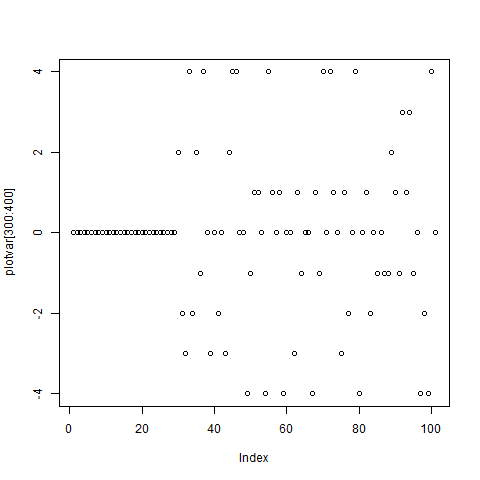

In [67]:
%%R
plotvar = data_expNN$DFam-(data_expNN$RFam-data_expNN$LFam)
plot(plotvar[300:400])

Hence DVal was recomputed.

In [68]:
data_expNN["DFam"]=data_expNN["RFam"]-data_expNN["LFam"]
data_expNN['zDFam']=data_expNN['DFam'].transform(lambda x: (x - x.mean()) / x.std())
%R -i data_expNN

Redoing the regression: All effects for zDFam are positive.

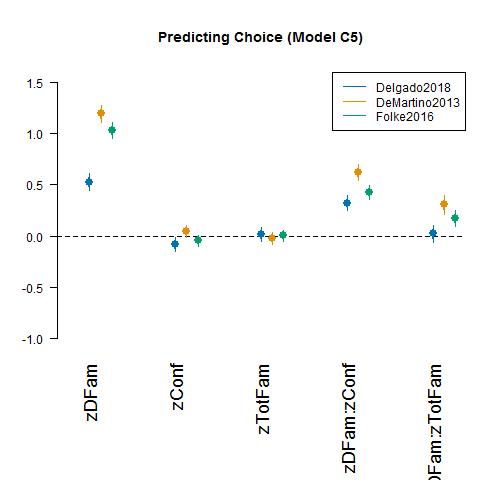

In [69]:
%%R
#regression for confidence and familiarity
title_plot = "Predicting Choice (Model C5)"

ModelChoiceFF_5 <- glm(Choice ~ zDFam + zConf +zTotFam + zDFam:zConf + zDFam:zTotFam , data=data_expFF, family=binomial(link="logit"))
ModelChoiceNN_5 <- glm(Choice ~ zDFam + zConf +zTotFam + zDFam:zConf + zDFam:zTotFam , data=data_expNN, family=binomial(link="logit"))
ModelChoiceNHB_5 <- glm(Choice ~ zDFam + zConf +zTotFam + zDFam:zConf + zDFam:zTotFam , data=data_expNHB, family=binomial(link="logit"))

# save string containing the predictors
Predictors_5 = "zDFam + zConf +zTotFam + zDFam:zConf + zDFam:TotFam"

coefplot(ModelChoiceFF_5,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-1.0, 1.5) ,main=title_plot)
coefplot(ModelChoiceNN_5, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
coefplot(ModelChoiceNHB_5, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018", "DeMartino2013","Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)

### Choice ~ zDVal + zConf + zDFam + zTotVal +zTotFam

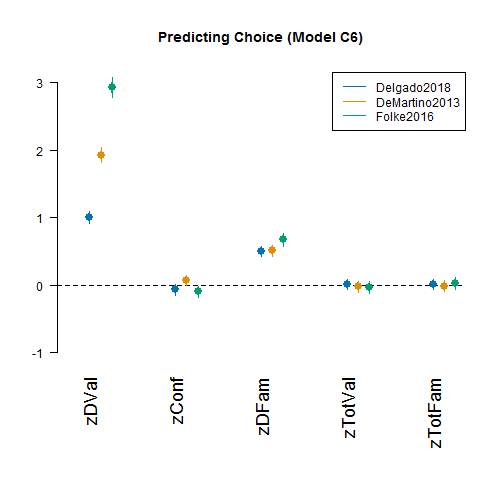

In [70]:
%%R
# regression for choice and familiarity
title_plot = "Predicting Choice (Model C6)"

ModelChoiceFF_6 <- glm(Choice ~ zDVal + zConf + zDFam + zTotVal +zTotFam, data=data_expFF, family=binomial(link="logit"))
ModelChoiceNN_6 <- glm(Choice ~ zDVal + zConf + zDFam + zTotVal+ zTotFam, data=data_expNN, family=binomial(link="logit"))
ModelChoiceNHB_6 <- glm(Choice ~ zDVal + zConf + zDFam + zTotVal+ zTotFam, data=data_expNHB, family=binomial(link="logit"))

# save string containing the predictors
Predictors_6 = "zDVal + zConf + zDFam + zTotVal +zTotFam"

coefplot(ModelChoiceFF_6,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-1.0, 3.0) ,main=title_plot)
coefplot(ModelChoiceNN_6, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
coefplot(ModelChoiceNHB_6, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018", "DeMartino2013","Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)

### Choice ~ zDVal + zDFam

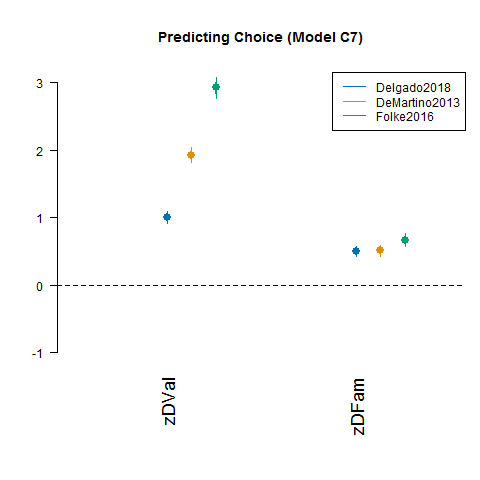

In [71]:
%%R
# regression for choice and familiarity
title_plot = "Predicting Choice (Model C7)"

ModelChoiceFF_7 <- glm(Choice ~ zDVal + zDFam , data=data_expFF, family=binomial(link="logit"))
ModelChoiceNN_7 <- glm(Choice ~ zDVal + zDFam , data=data_expNN, family=binomial(link="logit"))
ModelChoiceNHB_7 <- glm(Choice ~ zDVal + zDFam , data=data_expNHB, family=binomial(link="logit"))

# save string containing the predictors
Predictors_7 = "zDVal + zDFam"

coefplot(ModelChoiceFF_7,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-1.0, 3.0) ,main=title_plot)
coefplot(ModelChoiceNN_7, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
coefplot(ModelChoiceNHB_7, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018", "DeMartino2013","Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)

### Choice ~ zDV + zConf + zDFam + zDV:zConf + zDFam:zConf

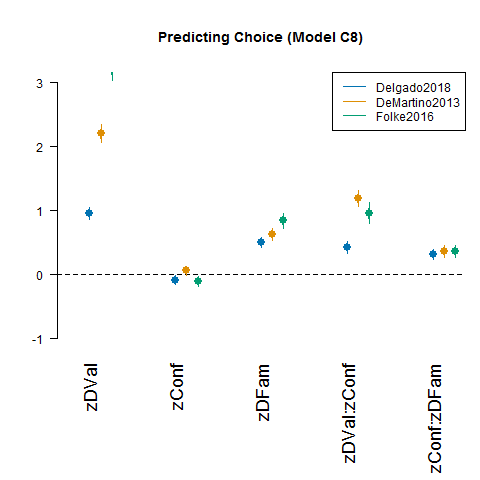

In [72]:
%%R
# regression for choice and familiarity
title_plot = "Predicting Choice (Model C8)"

ModelChoiceFF_8 <- glm(Choice ~ zDVal + zConf + zDFam + zDVal:zConf + zDFam:zConf, data=data_expFF, family=binomial(link="logit"))
ModelChoiceNN_8 <- glm(Choice ~ zDVal + zConf + zDFam + zDVal:zConf + zDFam:zConf, data=data_expNN, family=binomial(link="logit"))
ModelChoiceNHB_8 <- glm(Choice ~ zDVal + zConf + zDFam + zDVal:zConf + zDFam:zConf, data=data_expNHB, family=binomial(link="logit"))

# save string containing the predictors
Predictors_8 = "zDVal + zConf + zDFam + zDVal:zConf"

coefplot(ModelChoiceFF_8,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-1.0, 3.0) ,main=title_plot)
coefplot(ModelChoiceNN_8, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
coefplot(ModelChoiceNHB_8, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018", "DeMartino2013","Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)

## Interpretation & Notes
- zDFam predicts Choice even when zDVal is included
- Both zDVal and zDFam interact positivly with Confidence
    #### Questions:
    - What is the variance zDFam and zDVal explain independently
    - Why do zDVal and zDFam show the same effects?


# Predicting Confidence
---------------

### zConf ~ zChosenVal + zUnchosenVal + zChosenFam + zUnchosenFam +zRT

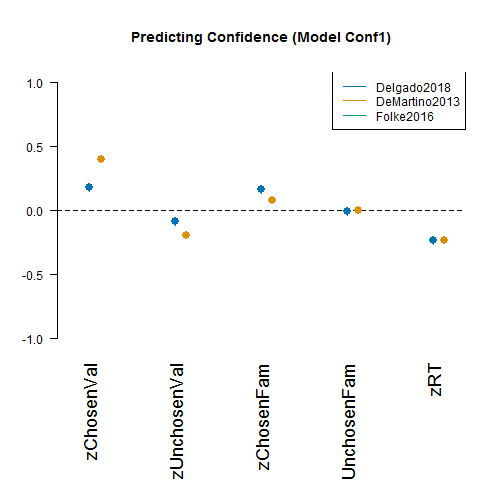

In [232]:
%%R
# Figure replicating Folke 2016. 
title_plot = "Predicting Confidence (Model Conf1)"

ModelConfidenceFF_1 <- glm(zConf ~ zChosenVal + zUnchosenVal + zChosenFam + zUnchosenFam +zRT , data=data_expFF)
ModelConfidenceNN_1 <- glm(zConf ~  zChosenVal + zUnchosenVal + zChosenFam + zUnchosenFam +zRT, data=data_expNN)
#ModelConfidenceNHB_1 <- glm(zConf ~ zChosenVal + zUnchosenVal + zChosenFam + zUnchosenFam  , data=data_expNHB)

# save string containing the predictors
PredictorsConf_1 = "zChosenVal + zUnchosenVal + zChosenFam + zUnchosenFam +zRT"

coefplot(ModelConfidenceFF_1,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-1, 1) ,main=title_plot)
coefplot(ModelConfidenceNN_1, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
#coefplot(ModelConfidenceNHB_1, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018", "DeMartino2013","Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)

### zConf ~ zTotVal + zTotFam + zDVal + zDFam +zRT

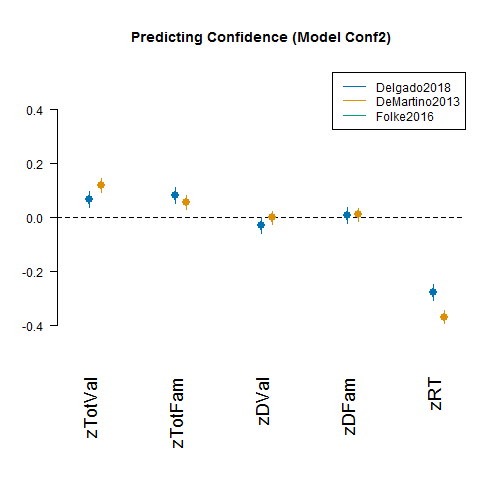

In [231]:
%%R
# Figure replicating Folke 2016. 
title_plot = "Predicting Confidence (Model Conf2)"

ModelConfidenceFF_2 <- glm(zConf ~ zTotVal + zTotFam + zDVal + zDFam +zRT , data=data_expFF)
ModelConfidenceNN_2 <- glm(zConf ~ zTotVal + zTotFam + zDVal + zDFam +zRT, data=data_expNN)
#ModelConfidenceNHB_1 <- glm(zConf ~ zChosenVal + zUnchosenVal + zChosenFam + zUnchosenFam  , data=data_expNHB)

# save string containing the predictors
PredictorsConf_2 = "zTotVal + zTotFam + zDVal + zDFam +zRT"

coefplot(ModelConfidenceFF_2,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-0.5, 0.5) ,main=title_plot)
coefplot(ModelConfidenceNN_2, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
#coefplot(ModelConfidenceNHB_1, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018", "DeMartino2013","Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)

Same behavior of Value and Familiarity, besides that unchosen Familiarity has no effect vs. unchosen Value that has.

# Predict Value
-----

### Difference in Value ~ LFam + RFam

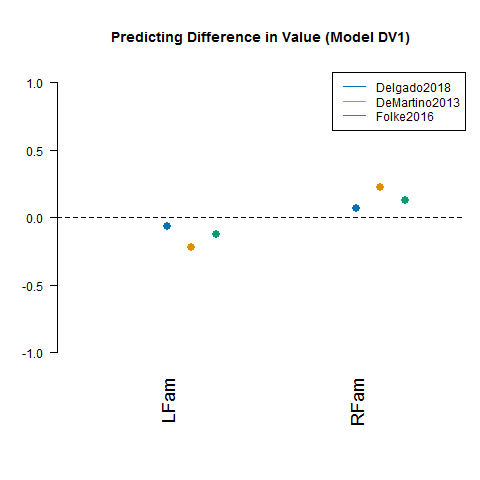

In [80]:
%%R
#regression for confidence and familiarity
title_plot = "Predicting Difference in Value (Model DV1)"

ModelDvFF_1 <- glm(zDVal~ LFam + RFam  , data=data_expFF)
ModelDvNN_1 <- glm(zDVal~ LFam + RFam , data=data_expNN)
ModelDvNHB_1 <- glm(zDVal~ LFam + RFam , data=data_expNHB)

# save string containing the predictors
PredictorsDv_1 = "LFam + RFam"

coefplot(ModelDvFF_1,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-1.0, 1.0) ,main=title_plot)
coefplot(ModelDvNN_1, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
coefplot(ModelDvNHB_1, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018", "DeMartino2013","Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)

# Reaction Time Analysis
-------

I wasn't sure how to model Reaction Times so I used a linear model on z-transformed RTs as well as a glm with underlying inverse.gaussian and inverse link function for every model.
DeMartino2013 wasn't modeled as there are some trials in the data that are weird. In those Trials RT was 0 as well as some other variables. These should probably be excluded...?

### zRT ~ zConf with linear regression

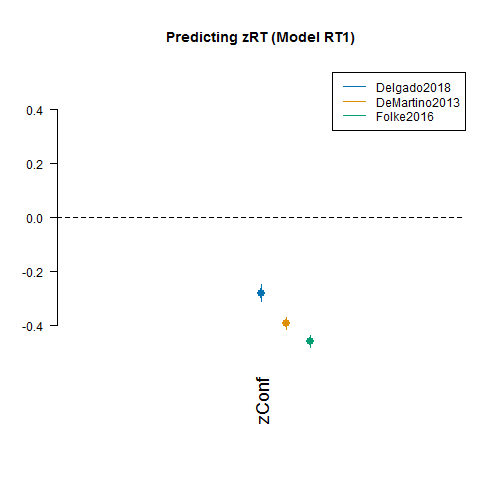

In [237]:
%%R
title_plot="Predicting zRT (Model RT1)"

ModelRtFF_1 <-glm(zRT ~ zConf , data=data_expFF )#, family = inverse.gaussian(link = "inverse"))
ModelRtNN_1 <-glm(zRT ~ zConf , data=data_expNN) #, family = inverse.gaussian(link = "inverse"))
ModelRtNHB_1<-glm(zRT ~ zConf , data=data_expNHB )#, family = inverse.gaussian(link = "inverse"))

coefplot(ModelRtFF_1,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-0.5,0.5),main=title_plot)
coefplot(ModelRtNN_1, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
coefplot(ModelRtNHB_1, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018","DeMartino2013", "Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)


### RT ~ zConf with inverse gaussian distribution
A very big difference between predictors (DeMartino Model is at -100)

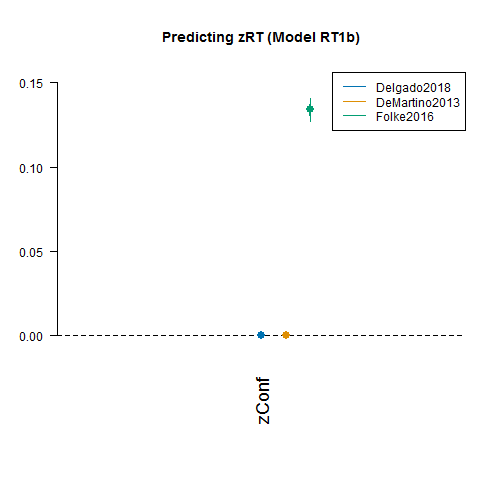

In [236]:
%%R
title_plot="Predicting zRT (Model RT1b)"

ModelRtFF_1b <-glm(RT ~ zConf , data=data_expFF , family = inverse.gaussian(link = "inverse"))
ModelRtNN_1b <-glm(RT ~ zConf , data=data_expNN , family = inverse.gaussian(link = "inverse"))
ModelRtNHB_1b<-glm(RT ~ zConf , data=data_expNHB , family = inverse.gaussian(link = "inverse"))

coefplot(ModelRtFF_1b,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-0.01,0.15),main=title_plot)
coefplot(ModelRtNN_1b, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
coefplot(ModelRtNHB_1b, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018","DeMartino2013", "Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)


### zRT ~ zDVal + zRFam + zLFam + zConf with linear regression

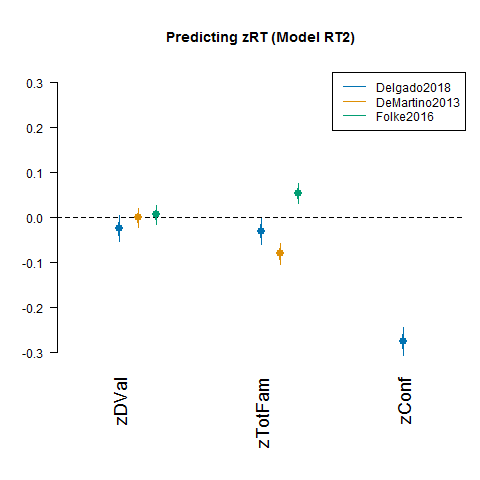

In [235]:
%%R

title_plot="Predicting zRT (Model RT2)"

ModelRtFF_2 <-glm(zRT ~zDVal +zTotFam+ zConf , data=data_expFF )#, family = inverse.gaussian(link = "inverse"))
ModelRtNN_2 <-glm(zRT ~zDVal +zTotFam+ zConf , data=data_expNN) #, family = inverse.gaussian(link = "inverse"))
ModelRtNHB_2 <-glm(zRT ~zDVal +zTotFam + zConf , data=data_expNHB )#, family = inverse.gaussian(link = "inverse"))

coefplot(ModelRtFF_2,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-0.3,0.3),main=title_plot)
coefplot(ModelRtNN_2, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
coefplot(ModelRtNHB_2, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018","DeMartino2013", "Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)


### zRT ~ zDVal + zRFam + zLFam + zConf with linear regression with inverse gaussian distribution
Confidence predictor from Folke 2016 is negative (not visible in the plot)

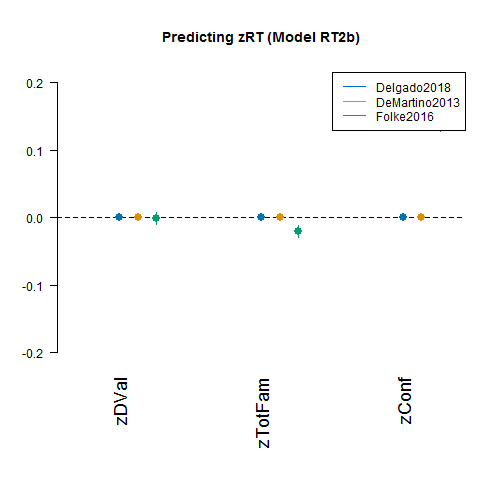

In [234]:
%%R
title_plot="Predicting zRT (Model RT2b)"

ModelRtFF_2b <-glm(RT ~zDVal +zTotFam + zConf , data=data_expFF , family = inverse.gaussian(link = "inverse"))
ModelRtNN_2b <-glm(RT ~zDVal +zTotFam+ zConf , data=data_expNN , family = inverse.gaussian(link = "inverse"))
ModelRtNHB_2b <-glm(RT ~zDVal +zTotFam+ zConf , data=data_expNHB , family = inverse.gaussian(link = "inverse"))

coefplot(ModelRtFF_2b,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-0.2,0.2),main=title_plot)
coefplot(ModelRtNN_2b, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
coefplot(ModelRtNHB_2b, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018","DeMartino2013", "Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)


The Coefficients for zRFam and zLFam are significant in Folke2016 but very small. To compare models BIC was computed and showed that the inclusion of regressors besides zConf doesn't improve the model.

In [178]:
%%R

BICModelRtFF_1=BIC(ModelRtFF_1)
BICModelRtNN_1=BIC(ModelRtNN_1)
BICModelRtNHB_1=BIC(ModelRtNHB_1)
BICModelRtFF_1b=BIC(ModelRtFF_1b)
BICModelRtNHB_1b=BIC(ModelRtNHB_1b)
BICModelRtFF_2=BIC(ModelRtFF_2)
BICModelRtNHB_2=BIC(ModelRtNHB_2)
BICModelRtFF_2b=BIC(ModelRtFF_2b)
BICModelRtNHB_2b=BIC(ModelRtNHB_2b)

allBICs<-(c(BICModelRtFF_1,BICModelRtNHB_1,BICModelRtNN_1,BICModelRtFF_1b,BICModelRtNHB_1b,BICModelRtFF_2,BICModelRtNHB_2,BICModelRtFF_2b,BICModelRtNHB_2b))

In [179]:
%R -o allBICs

In [180]:
print('BIC RT1 Delgado2018\t',allBICs[0])
print('BIC RT1 Folke2016\t',allBICs[1])
print('BIC RT1b Delgado2018\t',allBICs[3])
print('BIC RT1b Folke2016\t',allBICs[4])
print('BIC RT2 Delgado2018\t',allBICs[5])
print('BIC RT2 Folke2016\t',allBICs[6])
print('BIC RT2b Delgado2018\t',allBICs[7])
print('BIC RT2b Folke2016\t',allBICs[8])

BIC RT1 Delgado2018	 10228.401399020946
BIC RT1 Folke2016	 16483.23661570785
BIC RT1b Delgado2018	 66363.11842165861
BIC RT1b Folke2016	 16465.421612968355
BIC RT2 Delgado2018	 10237.595767601368
BIC RT2 Folke2016	 16478.369074503596
BIC RT2b Delgado2018	 66372.38077631265
BIC RT2b Folke2016	 16449.327310743585


Model including total Familiarity doesnt improve the model in Delgado 2018, but does so in Folke2016

### zRT ~ zChosenFam +zUnchosenFam+ zConf +zChosenFam:zConf+zUnchosenFam:zConf
From here on only the linear model as it seems to provide the better fit.

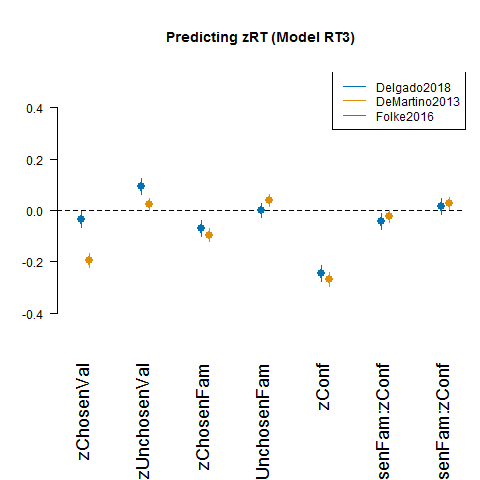

In [233]:
%%R
title_plot="Predicting zRT (Model RT3)"

ModelRtFF_3 <-glm(zRT ~zChosenVal +zUnchosenVal+zChosenFam +zUnchosenFam+ zConf +zChosenFam:zConf+zUnchosenFam:zConf, data=data_expFF)
ModelRtNN_3 <-glm(zRT ~zChosenVal +zUnchosenVal+zChosenFam +zUnchosenFam+ zConf +zChosenFam:zConf+zUnchosenFam:zConf, data=data_expNN)
#ModelRtNHB_3 <-glm(zRT ~zDVal +zChosenFam +zUnchosenFam+ zConf +zChosenFam:zConf+zUnchosenFam:zConf , data=data_expNHB)

coefplot(ModelRtFF_3,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-0.5,0.5),main=title_plot)
coefplot(ModelRtNN_3, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
#coefplot(ModelRtNHB_2b, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018","DeMartino2013", "Folke2016"),col=c(colorFF,colorNN,colorNHB), lty=1:1, cex=1)

BICModelRtFF_3 = BIC(ModelRtFF_3)
BICModelRtNN_3 = BIC(ModelRtNN_3)

In [190]:
%R -o  BICModelRtNN_3

In [191]:
%R -o  BICModelRtFF_3

In [192]:
print('Model only Conf Delgado:\t',allBICs[0])
print('Model only Conf DeMartino:\t',allBICs[2])
print('Model with Fam Delgado:\t\t',BICModelRtFF_3[0])
print('Model with Fam DeMartino:\t',BICModelRtNN_3[0])

Model only Conf Delgado:	 10228.401399020946
Model only Conf DeMartino:	 16079.836178444462
Model with Fam Delgado:		 10211.916909056363
Model with Fam DeMartino:	 15740.832829301922


Model including Familiarity of Chosen Value seems to improve the model in DeMartino2013 but not in Delgado2018. What to make of that? Should we put into consideration that 2 of the predictors are not different from 0?

Why are the coefficients so much smaller in Delgado 2018? -> something in data with the size of the variables probably -> check out later

Note the same pattern as in the Confidence regressions in Delgado2018. Unchosen Value has an effect, while unchosen Familiarity has not. However,it seems to be the other way round in DeMartino2013

# IF FAM HAS EFFECT ON RT:
Investigate in drift model at what stage FAM has an effect:
    1. Use best fitting model from Nature Communications paper
    2. Implement FAM in:
        - Drift Rate
        - Offset
        - Both
        - Non
    -> What would the different interpretations be?
    -> What if FAM has NO effect on RT?

# Note: Familiarity is behaves very much like value

# On Another Note
2 Stage Model of Decision Making:
    1. Stage: Seperate Accumulators for the two choice options
    2. Stage: Combined drifting Accumulator for Decision
- Belief Confidence gets computed from 1. Stage
- Decision Confidence might be directly dependent on belief confidences (has not been tested in paper Boldt 2017?)
    - Are the two opposit gradients of fMRI activity from De Martino 2013 in favor of this hypothesis?
    - How is the 2. Stage dependent on the first Stage (i.e. if its linearly dependent shouldn't there be no gradient, but equal activation?)
        - ...Remeber that total value has an influence... -> what does this imply? 

# Hypothesis:
-------
- Samples of any kind (in this case from perception+memory) are continously evaluated and transformed into time-varying value estimates
- The variation of this value estimate leads to computation of belief confidences
    -These belief confidences are then transformed into a decision confidence
- The estimated values are forwarded to a value comparison unit (operating DDM like)

-> This makes sense because 

## Familiarity for each item predicts Value and Confidence

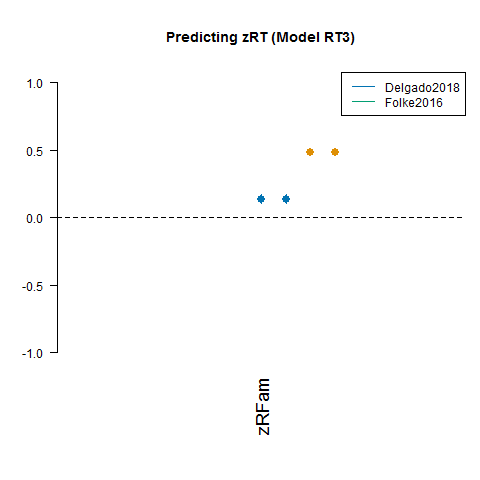

In [220]:
%%R
title_plot="Predicting zRT (Model RT3)"

ModelRtFF_3 <-glm(zRVal ~zRFam, data=data_expFF)
ModelRtFF_3b <-glm(zLVal ~zLFam, data=data_expFF)
ModelRtNN_3 <-glm(zRVal ~zRFam, data=data_expNN)
ModelRtNN_3b <-glm(zLVal ~zLFam, data=data_expNN)


#ModelRtNHB_3 <-glm(zRT ~zDVal +zChosenFam +zUnchosenFam+ zConf +zChosenFam:zConf+zUnchosenFam:zConf , data=data_expNHB)

coefplot(ModelRtFF_3,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1) ,ylim=c(-1,1),main=title_plot)
coefplot(ModelRtFF_3b, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorFF, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.13)
coefplot(ModelRtNN_3, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)
coefplot(ModelRtNN_3b, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.39)

#coefplot(ModelRtNHB_2b, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNHB, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.26)

legend("topright",  legend=c("Delgado2018", "Folke2016"),col=c(colorFF,colorNHB), lty=1:1, cex=1)

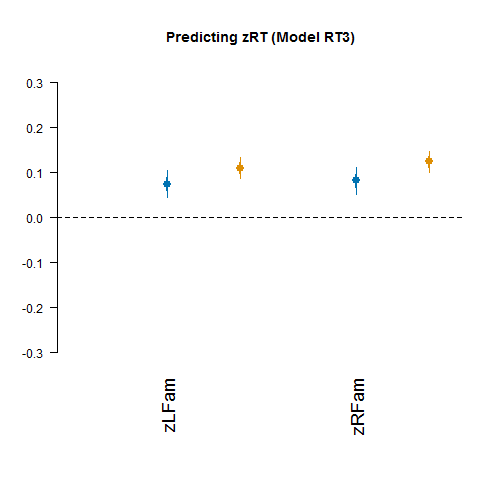

In [216]:
%%R
ModelRtFF_3c <-glm(zConf ~ zLFam+zRFam, data=data_expFF)
ModelRtNN_3c <-glm(zConf ~ zLFam+zRFam, data=data_expNN)
coefplot(ModelRtFF_3c,intercept=FALSE,vertical = FALSE,  col.pts=colorFF, cex.var=1.5, cex.pts=2.2, mar = c(8,4,5,1),offset=0.26,ylim=c(-.3,.3),main=title_plot)
coefplot(ModelRtNN_3c, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts=colorNN, cex.var=1.5, cex.pts=2.2,mar = c(8,4,5,1),offset=0.39)

In [60]:
data_expFF.to_csv(path_or_buf='D:\BDMLAB\export_datasets\data_expFF.csv')
data_expNN.to_csv(path_or_buf='D:\BDMLAB\export_datasets\data_expNN.csv')
data_expNHB.to_csv(path_or_buf='D:\BDMLAB\export_datasets\data_expNHB.csv')

# Some more plotting of the data

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


array([0.  , 0.08, 0.25, 0.33, 0.58, 0.83, 1.08, 1.33, 1.58, 1.83, 2.  ,
       2.08, 2.25, 2.33, 2.5 , 2.58, 2.75, 2.83, 3.08, 3.25, 3.33, 3.58,
       3.75, 3.83, 4.08, 4.25, 4.33, 4.58, 4.75, 4.83, 5.  ])

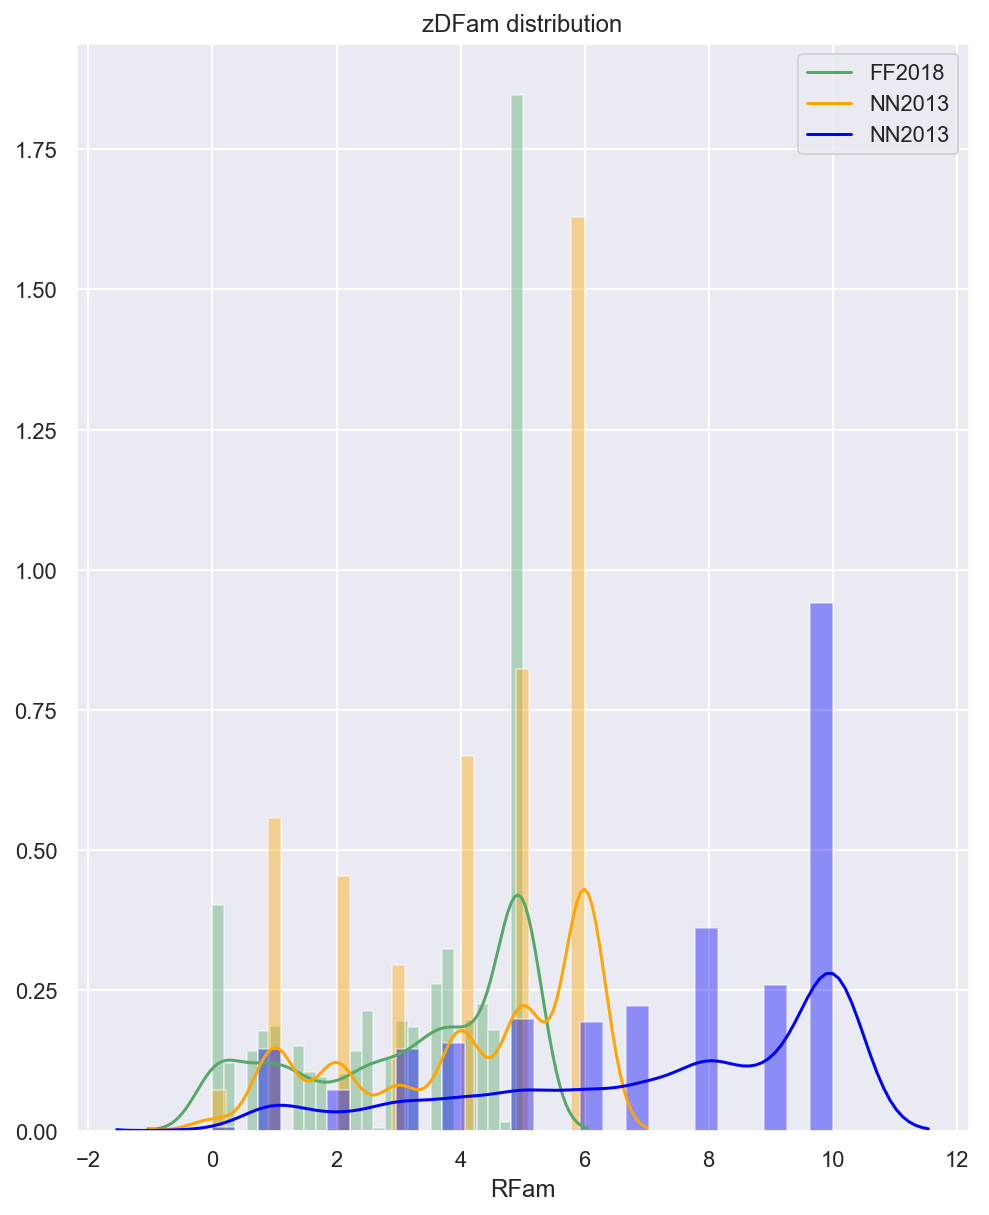

In [84]:

fig  = plt.figure(figsize=(8,10))

#sns.kdeplot(data_expFF['RFam'],shade=True,color='g',label="FF")
#sns.kdeplot(data_expNN['RFam'],shade=True,color='orange',label="NN")

sns.distplot(data_expFF['RFam'],color='g', kde_kws = {"label":"FF2018"}, bins = 27)
sns.distplot(data_expNN['RFam'],color='orange',kde_kws = {"label":"NN2013"}, bins = 27).set_title("zDFam distribution")
sns.distplot(data_expNHB['RFam'],color='blue',kde_kws = {"label":"NN2013"}, bins = 27).set_title("zDFam distribution")


#fig.set_title('Z-scored Familiarity',fontsize=18)
unique(data_expFF["RFam"])